<a href="https://colab.research.google.com/github/YEN-PO-CHEN/Colab/blob/main/DIP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install segmentation-models-pytorch

In [3]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)


# Loading data

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from os import listdir
from tqdm.notebook import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print("Use device:",DEVICE)

Use device: cuda:0


In [5]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/data'
Train_DIR = os.path.join(DATA_DIR, 'train')
Test_DIR = os.path.join(DATA_DIR, 'test')

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Train Data

In [7]:
CT = []
FT = []
MN = []
T1 = []
T2 = []
for idx in range(0,9):
  data = Train_DIR + "/{}/".format(idx)
  CT = CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  FT = FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  MN = MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  T1 = T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  T2 = T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]
CT.sort()
FT.sort()
MN.sort()
T1.sort()
T2.sort()

## Test Data

In [8]:
Test_CT = []
Test_FT = []
Test_MN = []
Test_T1 = []
Test_T2 = []
for idx in range(9,10):
  data = Test_DIR + "/{}/".format(idx)
  Test_CT = Test_CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  Test_FT = Test_FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  Test_MN = Test_MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  Test_T1 = Test_T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  Test_T2 = Test_T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]
Test_CT.sort()
Test_FT.sort()
Test_MN.sort()
Test_T1.sort()
Test_T2.sort()

# Data Loader

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [10]:
class Dataset(BaseDataset):
    """
    Args:
        image_path (dir): path to image(T1, T2)
        masks_path (dir): path to masks(CT, FT, MN)
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(
            self,
            image_path,
            masks_path,
            augmentation=None,
            preprocessing=None,
    ):
        self.T1 = image_path['T1']
        self.T2 = image_path['T2']
        self.CT = masks_path['CT']
        self.FT = masks_path['FT']
        self.MN = masks_path['MN']
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read data
        T1 = cv2.imread(self.T1[idx], cv2.IMREAD_GRAYSCALE)
        T2 = cv2.imread(self.T2[idx], cv2.IMREAD_GRAYSCALE)
        CT = cv2.imread(self.CT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        FT = cv2.imread(self.FT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        MN = cv2.imread(self.MN[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        zero = np.zeros((T1.shape[0],T1.shape[1]),dtype=np.uint8)
        image = np.stack((T1, T2, zero),axis = 2)
        mask = np.stack((CT, FT, MN),axis = 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image / 255, mask / 255
        
    def __len__(self):
        return len(self.T1)

In [11]:
import albumentations as albu

In [12]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf([albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
            ],p=0.9,),
        albu.OneOf([albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
            ],p=0.9,),
        albu.OneOf([albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
            ],p=0.9,),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

(320, 320, 3)


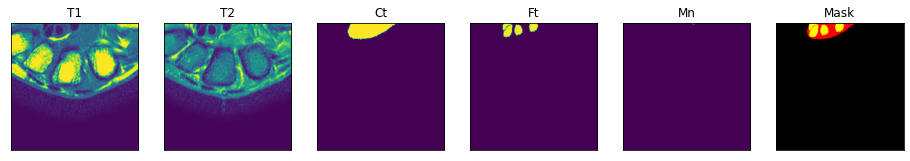

(320, 320, 3)


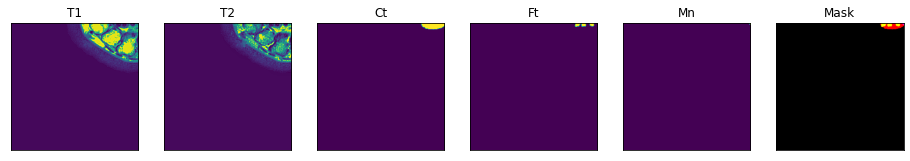

(320, 320, 3)


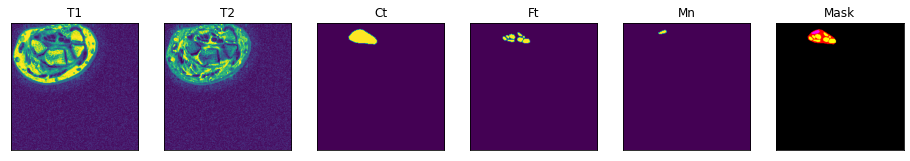

(320, 320, 3)


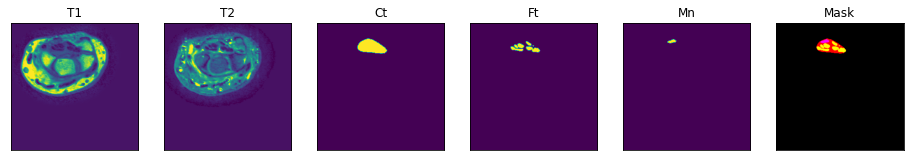

(320, 320, 3)


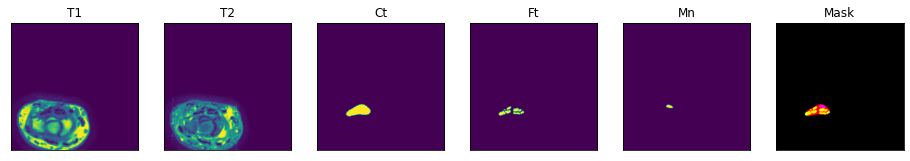

In [13]:
TrainSet = Dataset(image_path = {"T1":T1, "T2":T2},
          masks_path = {"CT":CT, "FT":FT, "MN":MN},
          augmentation=get_training_augmentation(),
          preprocessing=None,
          )
TestSet = Dataset(image_path = {"T1":Test_T1, "T2":Test_T2},
          masks_path = {"CT":Test_CT, "FT":Test_FT, "MN":Test_MN},
          augmentation=get_validation_augmentation(),
          preprocessing=None,
          )
for i in range(0,5):
  image, mask = TrainSet[i] # get some sample
  print(image.shape)
  visualize(
    T1 = image[:,:,0],
    T2 = image[:,:,1],
    CT = mask[:,:,0].squeeze(),
    FT = mask[:,:,1].squeeze(),
    MN = mask[:,:,2].squeeze(),
    MASK = mask
  )

# Train

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [15]:
from sklearn.model_selection import KFold
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')
model.to(DEVICE)

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [16]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
from torchsummary import summary

if torch.cuda.is_available():
  summary(model.cuda(), (2, 576, 576))
else:
  summary(model, (2, 576, 576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           6,272
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## K-fold Cross Validation

In [20]:
kf = KFold(n_splits=5,shuffle=False)

TrainData = np.array([T1,T2,CT,FT,MN])
TrainData = np.transpose(TrainData)
TestData = np.array([Test_T1,Test_T2,Test_CT,Test_FT,Test_MN])
TestData = np.transpose(TestData)
Train_loader = []
Valid_loader = []
for train_index , valid_index in kf.split(TrainData):
    max_score = 0
    TrainSet = Dataset(
              image_path = {"T1":T1[ train_index[0] : train_index[-1] ], "T2":T2[ train_index[0] : train_index[-1] ]},
              masks_path = {"CT":CT[ train_index[0] : train_index[-1] ], "FT":FT[ train_index[0] : train_index[-1] ], "MN":MN[ train_index[0] : train_index[-1] ]},
              augmentation=get_training_augmentation(),
              preprocessing=get_preprocessing(preprocessing_fn),
              )
    ValidSet = Dataset(
              image_path = {"T1":T1[ valid_index[0] : valid_index[-1] ], "T2":T2[ valid_index[0] : valid_index[-1] ]},
              masks_path = {"CT":CT[ valid_index[0] : valid_index[-1] ], "FT":FT[ valid_index[0] : valid_index[-1] ], "MN":MN[ valid_index[0] : valid_index[-1] ]},
              augmentation=get_validation_augmentation(),
              preprocessing=get_preprocessing(preprocessing_fn),
              )
    Train_loader.append(DataLoader(TrainSet, batch_size=8, shuffle=True, num_workers=12))
    Valid_loader.append(DataLoader(ValidSet, batch_size=1, shuffle=False, num_workers=4))

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [21]:
print(Valid_loader)
print(Train_loader)

[<torch.utils.data.dataloader.DataLoader object at 0x7ff8ceb9e910>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceba1e10>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceac4dd0>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceac43d0>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceba5d50>]
[<torch.utils.data.dataloader.DataLoader object at 0x7ff8d5587050>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceba1c10>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceac4f10>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8ceac4550>, <torch.utils.data.dataloader.DataLoader object at 0x7ff8cf5e6f50>]


In [22]:
 for i in range(0,5):
    for i in range(0, 50):
      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(Train_loader[i])
      valid_logs = valid_epoch.run(Valid_loader[i])
    
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/best_model.pth')
        print('Model saved!')
        print("max_score : ",max_score)
        
      if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train:   0%|          | 0/19 [00:03<?, ?it/s]


RuntimeError: ignored